In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,get_scorer_names,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def stats_by_feat(train,test,feat_to_stat,feat_to_group,func):
    for df in (train,test):
        df[feat_to_stat+feat_to_group+func] = df[feat_to_group].map(df.groupby(feat_to_group)[feat_to_stat].aggregate(func))


In [3]:
pd.options.display.max_columns=69

In [4]:
path = '/kaggle/input/measuring-student-persistence-and-completion-rate/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
registration = pd.read_csv(path+'registration.csv')

In [5]:
registration

,Student ID,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
0,0005f921-db87-47a3-af19-000332af236b,6,0,1,3,0,0,0,3,0,0,6,19
1,000f66b3-6ad7-4a6c-9f1f-0d34b005c5e6,0,0,7,0,0,0,0,1,0,0,0,8
2,001a2d9a-54ee-4ae9-91b4-d6fe03c98ce0,0,0,2,0,0,0,0,1,0,0,0,3
3,00235747-dd1a-4f59-be5b-4aeb66e037a1,0,0,1,0,0,0,0,0,0,0,0,1
4,00252da1-947b-4116-a096-852830ac0f89,0,0,1,1,0,0,0,1,0,0,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166,ffba6bca-a961-4881-a2a2-65fe664f345a,5,0,1,1,0,0,0,0,0,0,0,7
6167,ffd073f5-cf0d-4de3-b55f-f584f00f10fc,6,0,0,4,0,0,0,0,0,0,0,10
6168,ffd8a999-24dc-4ac8-8d58-3d77fc850f5d,1,1,1,1,0,0,0,0,0,0,0,4
6169,fffe70a7-43c5-4215-a432-6908f6dcf72c,4,0,2,2,0,0,0,1,0,0,5,14


In [6]:
test['ID'] = range(1,len(test)+1)

In [7]:
train = pd.merge(train,registration,on='Student ID')
test = pd.merge(test,registration,on='Student ID')

In [8]:
train

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,NaN,NaN,حضوري,2023-05-28,2023-06-08,12,نعم,البكالوريوس,هندسة حاسب الالي,NaN,2.44,4.0,غير موظف,NaN,NaN,0,4,0,0,0,0,0,0,0,0,0,0,4
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,خميس مشيط,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,NaN,متوسط,حضوري,2023-04-02,2023-04-06,5,نعم,البكالوريوس,الإذاعة والتلفزيون والفيلم,الفنون والعلوم الإنسانية,5.00,5.0,طالب,NaN,NaN,0,3,0,6,0,0,1,0,4,0,0,1,15
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,NaN,NaN,متوسط,حضوري,2023-07-23,2023-09-14,54,نعم,البكالوريوس,Information Technology,NaN,3.50,5.0,موظف,NaN,NaN,0,4,1,7,1,0,0,0,0,0,0,0,13
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,NaN,NaN,حضوري,2023-07-23,2023-08-24,33,نعم,البكالوريوس,حوسبة تطبيقية - (مسار شبكات الحاسب),NaN,3.55,5.0,خريج,NaN,NaN,0,4,0,0,2,0,0,0,0,0,0,0,6
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,حضوري,2023-04-30,2023-06-22,54,لا,البكالوريوس,نظم المعلومات الحاسوبية,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,0,0,0,4,0,0,0,0,3,0,0,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,NaN,NaN,حضوري,2023-04-02,2023-06-06,66,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,NaN,NaN,NaN,0,1,1,11,3,0,0,0,1,0,0,1,18
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,بريدة,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,عن بعد,2023-05-14,2023-05-25,12,نعم,البكالوريوس,علوم الحاسب,NaN,4.46,5.0,موظف,NaN,NaN,0,0,0,5,0,0,0,0,1,0,0,0,6
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,حضوري,2023-07-16,2023-07-20,5,لا,البكالوريوس,نظم المعلومات,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6,0,11,5,0,0,0,4,0,0,1,27
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,NaN,متوسط,حضوري,2024-01-07,2024-01-18,12,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0,0,0,0,0,0,0,0,0,0,3,3


In [9]:
registration

,Student ID,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
0,0005f921-db87-47a3-af19-000332af236b,6,0,1,3,0,0,0,3,0,0,6,19
1,000f66b3-6ad7-4a6c-9f1f-0d34b005c5e6,0,0,7,0,0,0,0,1,0,0,0,8
2,001a2d9a-54ee-4ae9-91b4-d6fe03c98ce0,0,0,2,0,0,0,0,1,0,0,0,3
3,00235747-dd1a-4f59-be5b-4aeb66e037a1,0,0,1,0,0,0,0,0,0,0,0,1
4,00252da1-947b-4116-a096-852830ac0f89,0,0,1,1,0,0,0,1,0,0,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166,ffba6bca-a961-4881-a2a2-65fe664f345a,5,0,1,1,0,0,0,0,0,0,0,7
6167,ffd073f5-cf0d-4de3-b55f-f584f00f10fc,6,0,0,4,0,0,0,0,0,0,0,10
6168,ffd8a999-24dc-4ac8-8d58-3d77fc850f5d,1,1,1,1,0,0,0,0,0,0,0,4
6169,fffe70a7-43c5-4215-a432-6908f6dcf72c,4,0,2,2,0,0,0,1,0,0,5,14


In [10]:
# test = test.merge(registration,on='Student ID')

In [11]:
# train = train.merge(registration,on='Student ID')

In [12]:
train['Home Region'].value_counts()

Home Region
منطقة الرياض             4783
منطقة مكة المكرمة         598
المنطقة الشرقية           450
منطقة المدينة المنورة     177
منطقة عسير                172
منطقة القصيم              103
منطقة جازان                59
منطقة تبوك                 50
منطقة الباحة               47
منطقة حائل                 36
منطقة نجران                29
منطقة الحدود الشمالية      21
منطقة الجوف                21
Name: count, dtype: int64

In [13]:
# for df in (train,test):
#     df['Gender']=df['Gender'].map({'أنثى':0,'ذكر':1})

In [14]:
cat_cols = list(train.select_dtypes(exclude='number').columns)
for col in cat_cols:
    print(col,train[col].nunique())

Student ID 5196
Gender 2
Home Region 13
Home City 92
Program ID 223
Program Main Category Code 10
Program Sub Category Code 11
Technology Type 3
Program Skill Level 3
Program Presentation Method 2
Program Start Date 77
Program End Date 88
Completed Degree 2
Level of Education 5
Education Speaciality 871
College 9
Employment Status 6
Job Type 4
Still Working 2


In [15]:
# traintest = pd.concat([train,test])

# tfidf = TfidfVectorizer()
# vec = tfidf.fit(traintest['Education Speaciality'].astype('str'))
# train_vectorized = tfidf.transform(train['Education Speaciality'].astype('str')).toarray()
# test_vectorized = tfidf.transform(test['Education Speaciality'].astype('str')).toarray()


In [16]:
# train_vec = pd.DataFrame(train_vectorized,columns=tfidf.get_feature_names_out())
# test_vec = pd.DataFrame(test_vectorized,columns=tfidf.get_feature_names_out())

In [17]:
# train = pd.concat([train,train_vec],axis=1)
# test = pd.concat([test,test_vec],axis=1)

In [18]:
test

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,ID,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
0,d8524ed6-a1b2-4f6f-9041-66eebcab899a,23.0,أنثى,منطقة الرياض,الرياض,451d680f-e067-41c0-a998-6b3da3963bca,CAUF,SWPS,تقليدية,متوسط,عن بعد,2023-10-08,2023-10-12,5,لا,البكالوريوس,علوم الحاسب الالي,NaN,3.72,4.0,خريج,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,1
1,5490b973-d85e-4b26-93a8-ecc11c47a5a0,31.0,أنثى,منطقة الرياض,الرياض,4957a013-46a7-419c-93d5-ebf3741ab2a1,PCRF,PCRF,تقليدية,مبتدئ,عن بعد,2023-07-16,2023-08-03,19,لا,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,2.00,4.0,NaN,NaN,NaN,2,0,0,2,0,0,0,0,0,0,0,12,14
2,3c1d99c8-f25b-4198-b904-aacb15164888,29.0,أنثى,منطقة الرياض,الرياض,03ec0d20-11cd-49bf-9b54-de5d12d4bd76,CAUF,SWPS,NaN,NaN,عن بعد,2022-12-25,2023-01-05,12,نعم,البكالوريوس,شبكات الحاسب الآلي,تكنولوجيا الاتصالات والمعلومات,3.72,5.0,موظف,دوام كامل,Yes,3,0,1,1,0,0,0,0,1,0,0,1,4
3,9e57ee90-2d60-48b8-91a1-7caa49f03810,23.0,أنثى,منطقة الرياض,الرياض,4ad7a7dc-abcf-43fa-b2e3-07095e083661,PCRF,PCRF,NaN,متقدم,حضوري,2023-03-19,2023-03-23,5,نعم,البكالوريوس,Biology,NaN,4.47,5.0,غير موظف,NaN,NaN,4,7,0,5,0,0,1,0,2,0,0,0,15
4,a11b482b-6cc3-4e1a-8b95-60ab2e42097a,30.0,أنثى,منطقة الرياض,الرياض,60494e5b-b20a-4440-ab75-0fd257748dcc,TOSL,NaN,داعمة,متقدم,حضوري,2023-11-12,2023-12-14,33,نعم,الدبلوم,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.46,5.0,غير موظف,دوام كامل,No,5,9,2,10,4,0,0,0,3,0,0,17,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,c4bd99a6-2902-4822-947e-2a3aab3f1e92,36.0,ذكر,منطقة الرياض,الرياض,1b546d80-2ed0-42e6-9867-61b3d2f92d50,GRST,INFA,NaN,متوسط,حضوري,2023-08-13,2023-08-17,5,نعم,البكالوريوس,علوم حاسب,NaN,2.55,5.0,موظف,NaN,NaN,814,0,1,0,0,0,0,0,0,0,0,0,1
814,2e057846-ee90-4b31-b6e7-c1c5122f4cbd,29.0,ذكر,منطقة الرياض,الرياض,aa87165d-cbde-4453-baca-1c8c03775e39,CAUF,CRDP,داعمة,مبتدئ,حضوري,2023-11-26,2024-01-11,47,نعم,البكالوريوس,الهندسة الكهربائية,الهندسة والتصنيع والبناء,3.00,4.0,NaN,NaN,NaN,815,0,0,1,0,0,0,0,0,0,0,3,4
815,8f9ff50d-510c-4d56-b0eb-60c2fb1c5e84,32.0,ذكر,منطقة الرياض,الرياض,c49987af-b421-4b88-b36a-a0ec91d95aa3,GRST,INFA,تقليدية,متوسط,حضوري,2023-07-23,2023-07-27,5,نعم,البكالوريوس,شبكات حاسب,NaN,3.00,5.0,موظف,NaN,NaN,816,2,2,0,1,0,0,0,0,0,0,0,5
816,8a49b6cd-e7c3-460b-8126-a419cf995e6e,28.0,أنثى,منطقة الرياض,الرياض,899795e1-7bf3-46d0-a58e-824d4033f6da,PCRF,PCRF,تقليدية,متوسط,عن بعد,2023-05-14,2023-11-02,173,لا,البكالوريوس,نظم معلومات حاسوبية,NaN,4.12,5.0,غير موظف,NaN,NaN,817,4,0,0,0,0,0,0,2,0,0,0,6


In [19]:
train

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,NaN,NaN,حضوري,2023-05-28,2023-06-08,12,نعم,البكالوريوس,هندسة حاسب الالي,NaN,2.44,4.0,غير موظف,NaN,NaN,0,4,0,0,0,0,0,0,0,0,0,0,4
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,خميس مشيط,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,NaN,متوسط,حضوري,2023-04-02,2023-04-06,5,نعم,البكالوريوس,الإذاعة والتلفزيون والفيلم,الفنون والعلوم الإنسانية,5.00,5.0,طالب,NaN,NaN,0,3,0,6,0,0,1,0,4,0,0,1,15
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,NaN,NaN,متوسط,حضوري,2023-07-23,2023-09-14,54,نعم,البكالوريوس,Information Technology,NaN,3.50,5.0,موظف,NaN,NaN,0,4,1,7,1,0,0,0,0,0,0,0,13
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,NaN,NaN,حضوري,2023-07-23,2023-08-24,33,نعم,البكالوريوس,حوسبة تطبيقية - (مسار شبكات الحاسب),NaN,3.55,5.0,خريج,NaN,NaN,0,4,0,0,2,0,0,0,0,0,0,0,6
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,حضوري,2023-04-30,2023-06-22,54,لا,البكالوريوس,نظم المعلومات الحاسوبية,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,0,0,0,4,0,0,0,0,3,0,0,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,NaN,NaN,حضوري,2023-04-02,2023-06-06,66,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,NaN,NaN,NaN,0,1,1,11,3,0,0,0,1,0,0,1,18
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,بريدة,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,عن بعد,2023-05-14,2023-05-25,12,نعم,البكالوريوس,علوم الحاسب,NaN,4.46,5.0,موظف,NaN,NaN,0,0,0,5,0,0,0,0,1,0,0,0,6
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,حضوري,2023-07-16,2023-07-20,5,لا,البكالوريوس,نظم المعلومات,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6,0,11,5,0,0,0,4,0,0,1,27
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,NaN,متوسط,حضوري,2024-01-07,2024-01-18,12,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0,0,0,0,0,0,0,0,0,0,3,3


# Feature Engineering

In [20]:
for df in train,test:
    df['Program Start Date'] = pd.to_datetime(df['Program Start Date'])
    df['starting month'] = df['Program Start Date'].dt.month
    df['starting year'] = df['Program Start Date'].dt.year
    
    
    

In [21]:
stats_by_feat(train,test,'Total Regestration','starting month','mean')




stats_by_feat(train,test,'PCRF','starting month','sum')
stats_by_feat(train,test,'PCRF','starting month','mean')
stats_by_feat(train,test,'PCRF','starting month','median')




# stats_by_feat(train,test,'N/A','starting month','mean')


# stats_by_feat(train,test,'Total Regestration','starting month','median')
# stats_by_feat(train,test,'Total Regestration','Home Region','mean')

In [22]:
train

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,starting month,starting year,Total Regestrationstarting monthmean,PCRFstarting monthsum,PCRFstarting monthmean,PCRFstarting monthmedian
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,NaN,NaN,حضوري,2023-05-28,2023-06-08,12,نعم,البكالوريوس,هندسة حاسب الالي,NaN,2.44,4.0,غير موظف,NaN,NaN,0,4,0,0,0,0,0,0,0,0,0,0,4,5,2023,9.992537,1617,2.413433,1.0
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,خميس مشيط,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,NaN,متوسط,حضوري,2023-04-02,2023-04-06,5,نعم,البكالوريوس,الإذاعة والتلفزيون والفيلم,الفنون والعلوم الإنسانية,5.00,5.0,طالب,NaN,NaN,0,3,0,6,0,0,1,0,4,0,0,1,15,4,2023,11.270872,1162,2.155844,1.0
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,NaN,NaN,متوسط,حضوري,2023-07-23,2023-09-14,54,نعم,البكالوريوس,Information Technology,NaN,3.50,5.0,موظف,NaN,NaN,0,4,1,7,1,0,0,0,0,0,0,0,13,7,2023,9.089692,1273,1.704150,0.0
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,NaN,NaN,حضوري,2023-07-23,2023-08-24,33,نعم,البكالوريوس,حوسبة تطبيقية - (مسار شبكات الحاسب),NaN,3.55,5.0,خريج,NaN,NaN,0,4,0,0,2,0,0,0,0,0,0,0,6,7,2023,9.089692,1273,1.704150,0.0
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,حضوري,2023-04-30,2023-06-22,54,لا,البكالوريوس,نظم المعلومات الحاسوبية,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,0,0,0,4,0,0,0,0,3,0,0,3,10,4,2023,11.270872,1162,2.155844,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,NaN,NaN,حضوري,2023-04-02,2023-06-06,66,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,NaN,NaN,NaN,0,1,1,11,3,0,0,0,1,0,0,1,18,4,2023,11.270872,1162,2.155844,1.0
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,بريدة,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,عن بعد,2023-05-14,2023-05-25,12,نعم,البكالوريوس,علوم الحاسب,NaN,4.46,5.0,موظف,NaN,NaN,0,0,0,5,0,0,0,0,1,0,0,0,6,5,2023,9.992537,1617,2.413433,1.0
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,حضوري,2023-07-16,2023-07-20,5,لا,البكالوريوس,نظم المعلومات,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6,0,11,5,0,0,0,4,0,0,1,27,7,2023,9.089692,1273,1.704150,0.0
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,NaN,متوسط,حضوري,2024-01-07,2024-01-18,12,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0,0,0,0,0,0,0,0,0,0,3,3,1,2024,8.840874,1054,1.644306,1.0


In [23]:
for df in (train,test):
    df.drop(columns=['Program Start Date','Program End Date','Education Speaciality','Home City'],inplace=True)             

In [24]:
train

,Student ID,Age,Gender,Home Region,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Days,Completed Degree,Level of Education,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,starting month,starting year,Total Regestrationstarting monthmean,PCRFstarting monthsum,PCRFstarting monthmean,PCRFstarting monthmedian
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,NaN,NaN,حضوري,12,نعم,البكالوريوس,NaN,2.44,4.0,غير موظف,NaN,NaN,0,4,0,0,0,0,0,0,0,0,0,0,4,5,2023,9.992537,1617,2.413433,1.0
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,NaN,متوسط,حضوري,5,نعم,البكالوريوس,الفنون والعلوم الإنسانية,5.00,5.0,طالب,NaN,NaN,0,3,0,6,0,0,1,0,4,0,0,1,15,4,2023,11.270872,1162,2.155844,1.0
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,NaN,NaN,متوسط,حضوري,54,نعم,البكالوريوس,NaN,3.50,5.0,موظف,NaN,NaN,0,4,1,7,1,0,0,0,0,0,0,0,13,7,2023,9.089692,1273,1.704150,0.0
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,NaN,NaN,حضوري,33,نعم,البكالوريوس,NaN,3.55,5.0,خريج,NaN,NaN,0,4,0,0,2,0,0,0,0,0,0,0,6,7,2023,9.089692,1273,1.704150,0.0
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,حضوري,54,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,0,0,0,4,0,0,0,0,3,0,0,3,10,4,2023,11.270872,1162,2.155844,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,NaN,NaN,حضوري,66,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,NaN,NaN,NaN,0,1,1,11,3,0,0,0,1,0,0,1,18,4,2023,11.270872,1162,2.155844,1.0
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,عن بعد,12,نعم,البكالوريوس,NaN,4.46,5.0,موظف,NaN,NaN,0,0,0,5,0,0,0,0,1,0,0,0,6,5,2023,9.992537,1617,2.413433,1.0
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,حضوري,5,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6,0,11,5,0,0,0,4,0,0,1,27,7,2023,9.089692,1273,1.704150,0.0
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,NaN,متوسط,حضوري,12,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0,0,0,0,0,0,0,0,0,0,3,3,1,2024,8.840874,1054,1.644306,1.0


In [25]:
for df in train,test:
#     df['Age'] = (df['Age']/10).round().astype('str')
    df['presntation_place'] = df['Program Presentation Method'] + df['Home Region']
#     df['Program Days'] = pd.cut(df['Program Days'],bins=[0,7,30,90,120,150,200,250,300],labels=['tiny','not short','short','medium','not long','long','very long','super long'])
    # df['studen_program'] = df['Student ID']+df['Program ID']
    

# EDA

In [26]:
train.describe()

,Age,Program Days,University Degree Score,University Degree Score System,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,starting month,starting year,Total Regestrationstarting monthmean,PCRFstarting monthsum,PCRFstarting monthmean,PCRFstarting monthmedian
count,6456.000000,6548.000000,6467.000000,6467.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.0,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000,6548.000000
mean,26.831165,19.691662,8.224432,9.773929,0.158674,1.856139,0.285278,2.961362,0.935247,0.110874,0.076970,0.0,1.666463,0.004123,0.012676,1.913867,9.884392,6.509316,2022.796426,9.884392,1068.621564,1.856139,0.493891
std,5.535967,32.112061,19.120384,21.259962,0.365400,3.357760,0.617338,4.496375,1.654361,0.396546,0.280524,0.0,2.640740,0.073000,0.111879,4.129517,11.960908,3.544787,0.434434,1.121495,292.354009,0.442094,0.500001
min,18.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2022.000000,8.584942,450.000000,1.067568,0.000000
25%,23.000000,5.000000,3.300000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2023.000000,8.840874,926.000000,1.518727,0.000000
50%,25.000000,12.000000,4.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,6.000000,7.000000,2023.000000,9.574751,1063.000000,1.765781,0.000000
75%,29.000000,19.000000,4.510000,5.000000,0.000000,2.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,2.000000,13.000000,10.000000,2023.000000,11.043541,1273.000000,2.155844,1.000000
max,57.000000,292.000000,100.000000,100.000000,1.000000,27.000000,4.000000,45.000000,13.000000,4.000000,2.000000,0.0,19.000000,2.000000,1.000000,47.000000,109.000000,12.000000,2024.000000,11.805556,1617.000000,2.735016,1.000000


In [27]:
train['Y'].value_counts()

Y
0    5509
1    1039
Name: count, dtype: int64

In [28]:
import seaborn 

<Axes: xlabel='Program Days', ylabel='Y'>

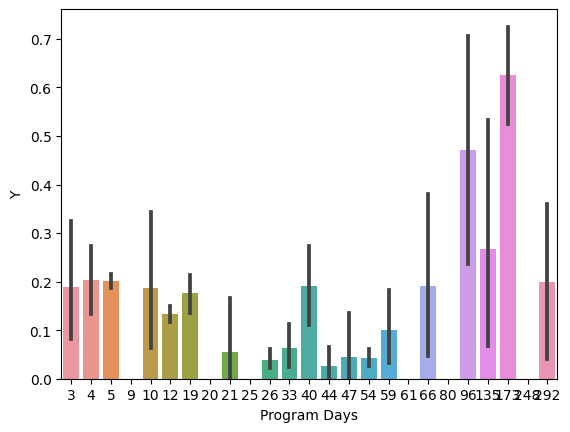

In [29]:
seaborn.barplot(train,x=train['Program Days'],y=train['Y'])

In [30]:
cat_cols = list(train.select_dtypes(exclude='number').columns)

for column in cat_cols:
    for df in train,test:
        df[column] = df[column].astype('str')

# for column in cat_cols:
#         traintest = pd.concat([train,test])
#         le.fit(traintest[column])
#         train[column] = le.transform(train[column])
#         test[column] = le.transform(test[column])

In [31]:
THRESHOLD = 0.3

# Cross Validation

In [32]:
model = CatBoostClassifier(random_state=42,cat_features=cat_cols)
stratfiedkfold = StratifiedKFold(shuffle=True,random_state=69,n_splits=10)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
def validate(trainset,testset):
    model.fit(trainset.drop(columns='Y'),trainset['Y'])
    model.set_probability_threshold(THRESHOLD)
    pred = model.predict(np.array(testset.drop(columns='Y')))
    score = f1_score(pred,testset['Y'])
    return score


In [35]:
train

,Student ID,Age,Gender,Home Region,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Days,Completed Degree,Level of Education,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,starting month,starting year,Total Regestrationstarting monthmean,PCRFstarting monthsum,PCRFstarting monthmean,PCRFstarting monthmedian,presntation_place
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,nan,nan,حضوري,12,نعم,البكالوريوس,nan,2.44,4.0,غير موظف,nan,nan,0,4,0,0,0,0,0,0,0,0,0,0,4,5,2023,9.992537,1617,2.413433,1.0,حضوريمنطقة الرياض
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,nan,متوسط,حضوري,5,نعم,البكالوريوس,الفنون والعلوم الإنسانية,5.00,5.0,طالب,nan,nan,0,3,0,6,0,0,1,0,4,0,0,1,15,4,2023,11.270872,1162,2.155844,1.0,حضوريمنطقة عسير
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,nan,nan,متوسط,حضوري,54,نعم,البكالوريوس,nan,3.50,5.0,موظف,nan,nan,0,4,1,7,1,0,0,0,0,0,0,0,13,7,2023,9.089692,1273,1.704150,0.0,حضوريمنطقة الرياض
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,nan,nan,حضوري,33,نعم,البكالوريوس,nan,3.55,5.0,خريج,nan,nan,0,4,0,0,2,0,0,0,0,0,0,0,6,7,2023,9.089692,1273,1.704150,0.0,حضوريمنطقة الرياض
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,حضوري,54,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,nan,nan,nan,0,0,0,4,0,0,0,0,3,0,0,3,10,4,2023,11.270872,1162,2.155844,1.0,حضوريمنطقة الرياض
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,nan,nan,حضوري,66,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,nan,nan,nan,0,1,1,11,3,0,0,0,1,0,0,1,18,4,2023,11.270872,1162,2.155844,1.0,حضوريمنطقة الرياض
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,nan,مبتدئ,عن بعد,12,نعم,البكالوريوس,nan,4.46,5.0,موظف,nan,nan,0,0,0,5,0,0,0,0,1,0,0,0,6,5,2023,9.992537,1617,2.413433,1.0,عن بعدمنطقة القصيم
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,حضوري,5,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6,0,11,5,0,0,0,4,0,0,1,27,7,2023,9.089692,1273,1.704150,0.0,حضوريمنطقة الرياض
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,nan,متوسط,حضوري,12,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0,0,0,0,0,0,0,0,0,0,3,3,1,2024,8.840874,1054,1.644306,1.0,حضوريمنطقة الرياض


In [36]:
f1 = []
rocauc = []
for v_train,v_test in stratfiedkfold.split(train.drop(columns='Y'),train['Y'].astype('str')+train['Home Region']):
    train_v, test_V= train.iloc[v_train],train.iloc[v_test]

    # training,testing = mean_encoding(train_v,test_V)
    # train_v,test_V = mean_encoding(train_v,test_V,'Level of Education')
    f1.append(validate(train_v,test_V))



/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Learning rate set to 0.021972
0:	learn: 0.6734698	total: 78.7ms	remaining: 1m 18s
1:	learn: 0.6548730	total: 90ms	remaining: 44.9s
2:	learn: 0.6367790	total: 127ms	remaining: 42.4s
3:	learn: 0.6201947	total: 134ms	remaining: 33.4s
4:	learn: 0.6040091	total: 157ms	remaining: 31.3s
5:	learn: 0.5889560	total: 180ms	remaining: 29.8s
6:	learn: 0.5740815	total: 202ms	remaining: 28.7s
7:	learn: 0.5607773	total: 227ms	remaining: 28.2s
8:	learn: 0.5482591	total: 241ms	remaining: 26.6s
9:	learn: 0.5341526	total: 264ms	remaining: 26.2s
10:	learn: 0.5227888	total: 289ms	remaining: 26s
11:	learn: 0.5120878	total: 310ms	remaining: 25.5s
12:	learn: 0.5018159	total: 319ms	remaining: 24.2s
13:	learn: 0.4919314	total: 339ms	remaining: 23.9s
14:	learn: 0.4817546	total: 366ms	remaining: 24s
15:	learn: 0.4724203	total: 391ms	remaining: 24.1s
16:	learn: 0.4639065	total: 404ms	remaining: 23.3s
17:	learn: 0.4550391	total: 428ms	remaining: 23.3s
18:	learn: 0.4477309	total: 440ms	remaining: 22.7s
19:	learn: 0.4

In [37]:
np.array(f1).mean()


0.6787771398201354

In [38]:
np.array(f1).std()


0.021522026422561753

In [39]:
f1


[0.7246376811594203,
 0.6666666666666667,
 0.6666666666666667,
 0.6889952153110048,
 0.6872246696035242,
 0.6728971962616822,
 0.6886792452830189,
 0.6877828054298643,
 0.6375545851528385,
 0.6666666666666667]

In [40]:
train

,Student ID,Age,Gender,Home Region,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Days,Completed Degree,Level of Education,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,starting month,starting year,Total Regestrationstarting monthmean,PCRFstarting monthsum,PCRFstarting monthmean,PCRFstarting monthmedian,presntation_place
0,4f14c50d-162e-4a15-9cf0-ec129c33bcf0,37.0,ذكر,منطقة الرياض,453686d8-4023-4506-b2df-fac8b059ac26,PCRF,PCRF,nan,nan,حضوري,12,نعم,البكالوريوس,nan,2.44,4.0,غير موظف,nan,nan,0,4,0,0,0,0,0,0,0,0,0,0,4,5,2023,9.992537,1617,2.413433,1.0,حضوريمنطقة الرياض
1,0599d409-876b-41a5-af05-749ef0e77d32,21.0,ذكر,منطقة عسير,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,APMR,SWPS,nan,متوسط,حضوري,5,نعم,البكالوريوس,الفنون والعلوم الإنسانية,5.00,5.0,طالب,nan,nan,0,3,0,6,0,0,1,0,4,0,0,1,15,4,2023,11.270872,1162,2.155844,1.0,حضوريمنطقة عسير
2,38a11c0e-4afc-4261-9c64-e94cc0a272fb,24.0,ذكر,منطقة الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,APMR,nan,nan,متوسط,حضوري,54,نعم,البكالوريوس,nan,3.50,5.0,موظف,nan,nan,0,4,1,7,1,0,0,0,0,0,0,0,13,7,2023,9.089692,1273,1.704150,0.0,حضوريمنطقة الرياض
3,1693e85b-f80e-40ce-846f-395ddcece6d3,23.0,ذكر,منطقة الرياض,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,TOSL,TOSL,nan,nan,حضوري,33,نعم,البكالوريوس,nan,3.55,5.0,خريج,nan,nan,0,4,0,0,2,0,0,0,0,0,0,0,6,7,2023,9.089692,1273,1.704150,0.0,حضوريمنطقة الرياض
4,98a0e8d0-5f80-4634-afd8-322aa0902863,23.0,ذكر,منطقة الرياض,d32da0e9-1aed-48c3-992d-a22f9ccc741e,CAUF,SWPS,تقليدية,متوسط,حضوري,54,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,nan,nan,nan,0,0,0,4,0,0,0,0,3,0,0,3,10,4,2023,11.270872,1162,2.155844,1.0,حضوريمنطقة الرياض
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,cd196579-9590-441b-8787-41078f3cee25,31.0,أنثى,منطقة الرياض,4f8c696a-b783-4d40-9776-105f6d3bd624,CAUF,SWPS,nan,nan,حضوري,66,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.40,5.0,nan,nan,nan,0,1,1,11,3,0,0,0,1,0,0,1,18,4,2023,11.270872,1162,2.155844,1.0,حضوريمنطقة الرياض
6544,37bfc11c-ff8c-42dc-9cf9-0d13bb8f7131,27.0,أنثى,منطقة القصيم,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,nan,مبتدئ,عن بعد,12,نعم,البكالوريوس,nan,4.46,5.0,موظف,nan,nan,0,0,0,5,0,0,0,0,1,0,0,0,6,5,2023,9.992537,1617,2.413433,1.0,عن بعدمنطقة القصيم
6545,fc114302-a79f-439f-a08b-fe0a51cf839e,24.0,أنثى,منطقة الرياض,02ae0b47-64a6-47a1-b3c5-c0e4df393c30,PCRF,PCRF,تقليدية,مبتدئ,حضوري,5,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.93,5.0,موظف,دوام كامل,Yes,1,6,0,11,5,0,0,0,4,0,0,1,27,7,2023,9.089692,1273,1.704150,0.0,حضوريمنطقة الرياض
6546,4b6d9a36-4402-4c75-bc3a-fca927dbaf65,25.0,ذكر,منطقة الرياض,9b4cedaa-fac0-4eac-aa4b-b05b6a0c97ff,PCRF,PCRF,nan,متوسط,حضوري,12,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,غير موظف,تدريب,No,0,0,0,0,0,0,0,0,0,0,0,3,3,1,2024,8.840874,1054,1.644306,1.0,حضوريمنطقة الرياض


In [41]:
model.fit(train.drop(columns='Y'),train['Y'])
model.set_probability_threshold(THRESHOLD)

Learning rate set to 0.022983
0:	learn: 0.6721630	total: 12.2ms	remaining: 12.1s
1:	learn: 0.6521707	total: 28.4ms	remaining: 14.2s
2:	learn: 0.6331625	total: 52.7ms	remaining: 17.5s
3:	learn: 0.6146120	total: 72.1ms	remaining: 17.9s
4:	learn: 0.5982116	total: 84.8ms	remaining: 16.9s
5:	learn: 0.5827627	total: 95.7ms	remaining: 15.9s
6:	learn: 0.5679975	total: 120ms	remaining: 17s
7:	learn: 0.5544004	total: 127ms	remaining: 15.8s
8:	learn: 0.5405891	total: 139ms	remaining: 15.3s
9:	learn: 0.5270634	total: 163ms	remaining: 16.1s
10:	learn: 0.5157953	total: 170ms	remaining: 15.2s
11:	learn: 0.5038568	total: 190ms	remaining: 15.7s
12:	learn: 0.4922678	total: 217ms	remaining: 16.5s
13:	learn: 0.4814969	total: 240ms	remaining: 16.9s
14:	learn: 0.4712816	total: 263ms	remaining: 17.3s
15:	learn: 0.4622527	total: 286ms	remaining: 17.6s
16:	learn: 0.4537217	total: 306ms	remaining: 17.7s
17:	learn: 0.4453283	total: 327ms	remaining: 17.8s
18:	learn: 0.4385497	total: 335ms	remaining: 17.3s
19:	lea

In [42]:
test

,Student ID,Age,Gender,Home Region,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Days,Completed Degree,Level of Education,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,ID,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,starting month,starting year,Total Regestrationstarting monthmean,PCRFstarting monthsum,PCRFstarting monthmean,PCRFstarting monthmedian,presntation_place
0,d8524ed6-a1b2-4f6f-9041-66eebcab899a,23.0,أنثى,منطقة الرياض,451d680f-e067-41c0-a998-6b3da3963bca,CAUF,SWPS,تقليدية,متوسط,عن بعد,5,لا,البكالوريوس,nan,3.72,4.0,خريج,nan,nan,1,0,0,1,0,0,0,0,0,0,0,0,1,10,2023,8.986486,110,1.486486,0.0,عن بعدمنطقة الرياض
1,5490b973-d85e-4b26-93a8-ecc11c47a5a0,31.0,أنثى,منطقة الرياض,4957a013-46a7-419c-93d5-ebf3741ab2a1,PCRF,PCRF,تقليدية,مبتدئ,عن بعد,19,لا,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,2.00,4.0,nan,nan,nan,2,0,0,2,0,0,0,0,0,0,0,12,14,7,2023,9.896907,178,1.835052,0.0,عن بعدمنطقة الرياض
2,3c1d99c8-f25b-4198-b904-aacb15164888,29.0,أنثى,منطقة الرياض,03ec0d20-11cd-49bf-9b54-de5d12d4bd76,CAUF,SWPS,nan,nan,عن بعد,12,نعم,البكالوريوس,تكنولوجيا الاتصالات والمعلومات,3.72,5.0,موظف,دوام كامل,Yes,3,0,1,1,0,0,0,0,1,0,0,1,4,12,2022,9.089552,84,1.253731,0.0,عن بعدمنطقة الرياض
3,9e57ee90-2d60-48b8-91a1-7caa49f03810,23.0,أنثى,منطقة الرياض,4ad7a7dc-abcf-43fa-b2e3-07095e083661,PCRF,PCRF,nan,متقدم,حضوري,5,نعم,البكالوريوس,nan,4.47,5.0,غير موظف,nan,nan,4,7,0,5,0,0,1,0,2,0,0,0,15,3,2023,11.432432,146,1.972973,0.0,حضوريمنطقة الرياض
4,a11b482b-6cc3-4e1a-8b95-60ab2e42097a,30.0,أنثى,منطقة الرياض,60494e5b-b20a-4440-ab75-0fd257748dcc,TOSL,nan,داعمة,متقدم,حضوري,33,نعم,الدبلوم,تكنولوجيا الاتصالات والمعلومات,4.46,5.0,غير موظف,دوام كامل,No,5,9,2,10,4,0,0,0,3,0,0,17,45,11,2023,7.186047,68,0.790698,0.0,حضوريمنطقة الرياض
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,c4bd99a6-2902-4822-947e-2a3aab3f1e92,36.0,ذكر,منطقة الرياض,1b546d80-2ed0-42e6-9867-61b3d2f92d50,GRST,INFA,nan,متوسط,حضوري,5,نعم,البكالوريوس,nan,2.55,5.0,موظف,nan,nan,814,0,1,0,0,0,0,0,0,0,0,0,1,8,2023,9.861111,79,2.194444,0.5,حضوريمنطقة الرياض
814,2e057846-ee90-4b31-b6e7-c1c5122f4cbd,29.0,ذكر,منطقة الرياض,aa87165d-cbde-4453-baca-1c8c03775e39,CAUF,CRDP,داعمة,مبتدئ,حضوري,47,نعم,البكالوريوس,الهندسة والتصنيع والبناء,3.00,4.0,nan,nan,nan,815,0,0,1,0,0,0,0,0,0,0,3,4,11,2023,7.186047,68,0.790698,0.0,حضوريمنطقة الرياض
815,8f9ff50d-510c-4d56-b0eb-60c2fb1c5e84,32.0,ذكر,منطقة الرياض,c49987af-b421-4b88-b36a-a0ec91d95aa3,GRST,INFA,تقليدية,متوسط,حضوري,5,نعم,البكالوريوس,nan,3.00,5.0,موظف,nan,nan,816,2,2,0,1,0,0,0,0,0,0,0,5,7,2023,9.896907,178,1.835052,0.0,حضوريمنطقة الرياض
816,8a49b6cd-e7c3-460b-8126-a419cf995e6e,28.0,أنثى,منطقة الرياض,899795e1-7bf3-46d0-a58e-824d4033f6da,PCRF,PCRF,تقليدية,متوسط,عن بعد,173,لا,البكالوريوس,nan,4.12,5.0,غير موظف,nan,nan,817,4,0,0,0,0,0,0,2,0,0,0,6,5,2023,8.495146,252,2.446602,1.0,عن بعدمنطقة الرياض


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

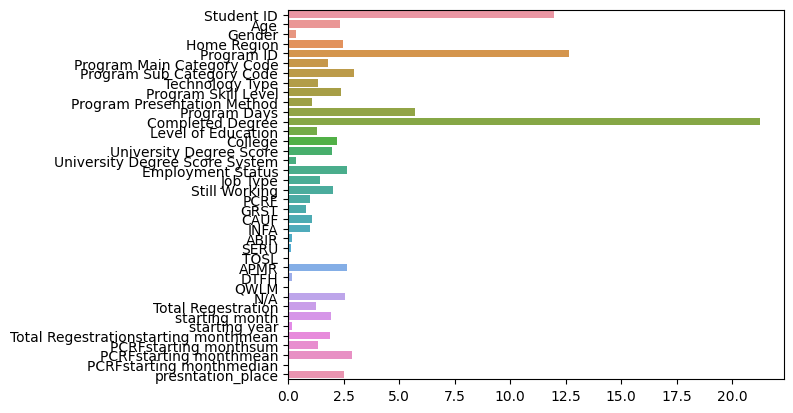

In [43]:
seaborn.barplot(x=model.feature_importances_,y=model.feature_names_)

In [44]:
pred = model.predict(test.drop(columns='ID'))

In [45]:
sub = pd.DataFrame({
    'ID':test['ID'],
    'Y':pred
})

In [46]:
# sub['Y'] = sub['Y'].map({1:0,0:1})

In [47]:
sub.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


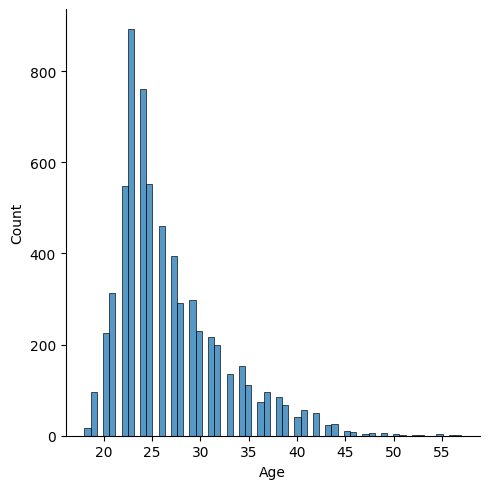

In [48]:
seaborn.displot(train['Age'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


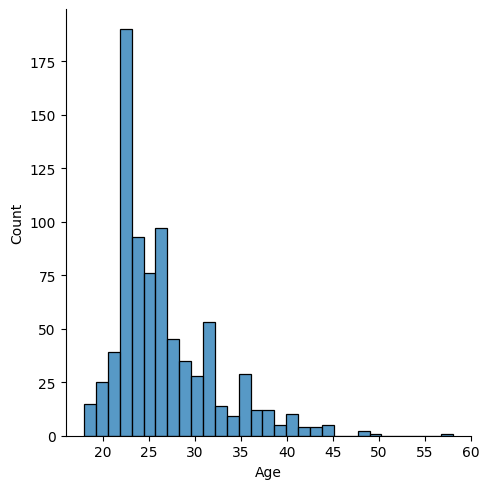

In [49]:
seaborn.displot(test['Age'])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Count', ylabel='Home Region'>

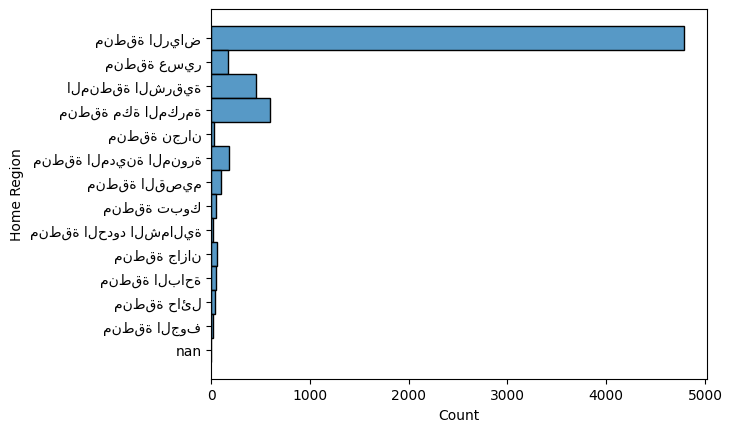

In [50]:
seaborn.histplot(y=train['Home Region'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Count', ylabel='Home Region'>

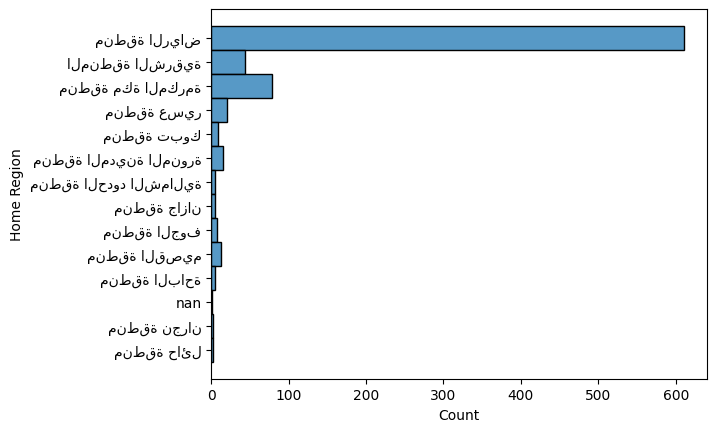

In [51]:
seaborn.histplot(y=test['Home Region'])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


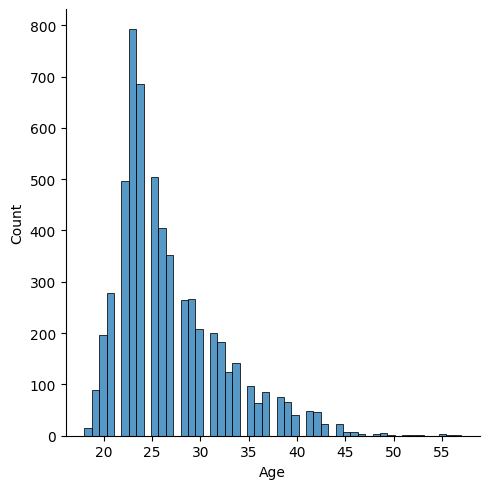

In [52]:
seaborn.displot(train_v['Age'])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


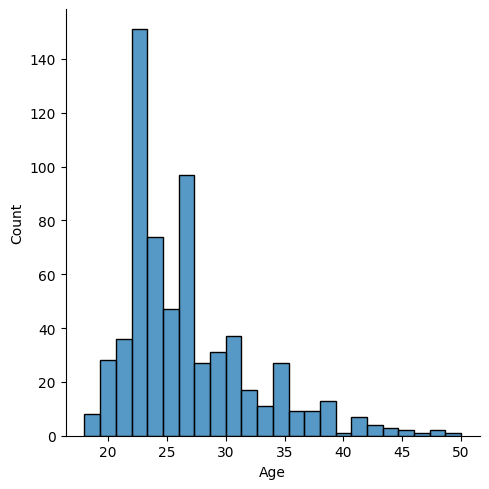

In [53]:
seaborn.displot(test_V['Age'])